In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [56]:
import warnings
warnings.filterwarnings("ignore")
import logging 
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import tensorflow as tf
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [57]:
PROJECT_PATH = '../'
sys.path.insert(0, PROJECT_PATH)

In [58]:
# def save_rbf(spvals, slogflux, snflux, spc, sv, wave, SAVE_RBF_PATH):
#     with h5py.File(SAVE_RBF_PATH, 'w') as f:
#         f.create_dataset('pc',   data = spc, shape=spc.shape)
#         f.create_dataset('logflux', data = slogflux, shape=slogflux.shape)
#         f.create_dataset('normflux', data = snflux, shape=snflux.shape)
#         f.create_dataset('eigv', data = sv, shape = sv.shape)
# #         f.create_dataset('eigs', data = rbf.grid.eigs['flux'], shape = rbf.grid.eigs['flux'].shape)
#         f.create_dataset('wave', data = wave, shape = wave.shape)
#         f.create_dataset('pval', data = spvals, shape=spvals.shape)
#         f.create_dataset("rbf_path", data = RBF_PATH)

In [112]:
Ws = {"Blue": [3800, 6500, 2300, "Blue"], "RedL": [6300, 9700, 3000, "RedL"], "RedM": [7100, 8850, 5000, "RedM"],
                   "NIR": [9400, 12600, 4300, "NIR"]}
Rs = {"M": ["M31 Giant", "M31"], "W": ["MW Warm","MWW"], "C": ["MW Cool","MWC"],
      "B": ["BHB","BHB"], "R": ["RHB","RHB"], "G":["DwarfG Giant", "DGG"]}
Ps = {"M": [[-2.5, 0.0], [3500, 5000], [0.0, 2.0],[-0.75, 0.5], [-0.25, 0.5]], 
      "W": [[-2.0, 0.0], [5500, 7500], [3.5, 5.0],[-0.75, 0.5], [-0.25, 0.5]],
      "C": [[-2.0, 0.0], [4500, 6000], [4.0, 5.0],[-0.75, 0.5], [-0.25, 0.5]], 
      "B": [[-2.5,-1.5], [7000, 9500], [2.0, 3.0],[-0.75, 0.5], [-0.25, 0.5]],
      "R": [[-1.0, 0.0], [5000, 6500], [2.0, 3.0],[-0.75, 0.5], [-0.25, 0.5]], 
      "G": [[-2.5,-1.0], [3500, 5500], [0.0, 3.5],[-0.75, 0.5], [-0.25, 0.5]]}

# BHB Blue

In [145]:
W, R, P = Ws["Blue"], Rs["B"], Ps["B"]
WR = R[1] + " " +  W[3] + "Arm"
Prng = np.diff(P).T

In [99]:
SRBF_PATH = f"/scratch/ceph/swei20/data/dnn/{R[1]}/rbf_{W[3]}_R{W[2]}_100k.h5"
SRBFT_PATH = f"/scratch/ceph/swei20/data/dnn/{R[1]}/rbf_{W[3]}_R{W[2]}_1k.h5"

In [93]:
with h5py.File(SRBF_PATH, 'r') as f:
    logflux = f['logflux'][()]
    normflux = f['normflux'][()]
    pc = f['pc'][()]
    wave = f['wave'][()]
    pval = f['pval'][()]
    pnorm=f['pnorm'][()]
logflux.shape, normflux.shape, pc.shape, wave.shape,pval.shape,pnorm.shape

((100000, 5368),
 (100000, 5368),
 (100000, 2000),
 (5368,),
 (100000, 5),
 (100000, 5))

In [94]:
with h5py.File(SRBFT_PATH, 'r') as f:
    normfluxT = f['normflux'][()]
    pcT = f['pc'][()]
    pvalT = f['pval'][()]
    pnormT=f['pnorm'][()]

In [95]:
DNN_PCP_PATH= f"/scratch/ceph/swei20/data/dnn/{R[1]}/bosz_pcp.h5"

In [100]:
with h5py.File(DNN_PCP_PATH, 'r') as f:
    pcp = f[f'pcp{W[3][0]}'][()]
    pc  = f[f'pc{W[3][0]}'][()]

In [101]:
pcpflux = normflux.dot(pcp.T)
pcflux = normflux.dot(pc.T)
pcpflux.shape, pcflux.shape

((100000, 80), (100000, 200))

In [102]:
pcpfluxT = normfluxT.dot(pcp.T)
pcfluxT = normfluxT.dot(pc.T)
pcpfluxT.shape, pcfluxT.shape

((1000, 80), (1000, 200))

In [103]:
def pcpflux_top(pcpflux, top=1):
    nidx = np.arange(pcpflux.shape[1]).reshape(4, -1)    
    idx = nidx[:,:top].reshape(-1)    
    return pcpflux[:,idx]

In [152]:
from dnn.model.dnn_model import DNN

In [153]:
dp=0.01
ep=1000
lr=0.01
y_train, y_test = pnorm, pnormT

Layers: [20, 128, 64, 32, 5]
(100000, 20)
| EP 1000 |loss: 0.0038 | mean_: 0.0038 | val_l: 0.0002 | val_m: 0.0002 | lr: 0.0000 | 


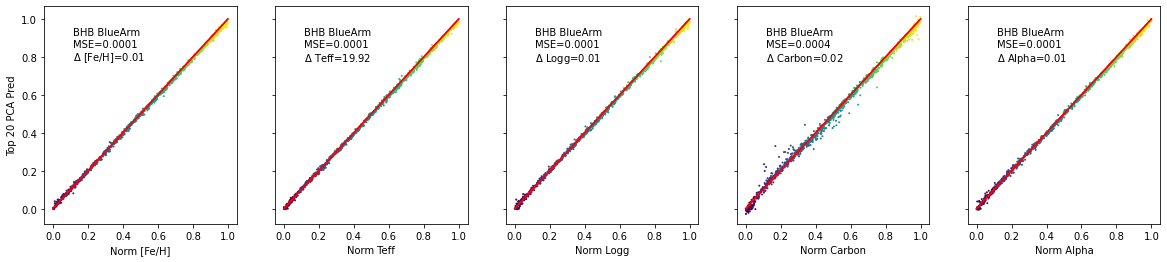

In [164]:
mtype="PCA"
top=20
x_train, x_test = pcflux, pcfluxT
d = DNN(input_dim=top, hidden_dims=[], dp=dp, lr=lr, mtype=mtype)
d.build_model()
d.fit(x_train, y_train, top=top, ep=ep,verbose=0)
y_pred=d.eval(x_test, y_test, WR, Prng)

Layers: [60, 128, 64, 32, 5]
(100000, 60)
| EP 1000 |loss: 0.0040 | mean_: 0.0040 | val_l: 0.0002 | val_m: 0.0002 | lr: 0.0001 | 


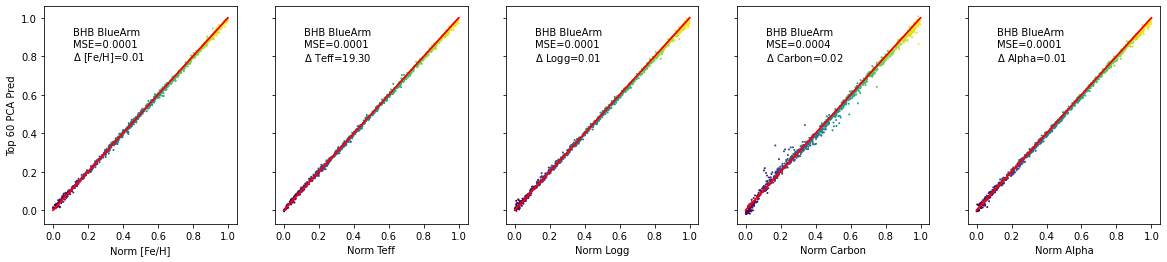

In [165]:
mtype="PCA"
top=60
x_train, x_test = pcflux, pcfluxT
d = DNN(input_dim=top, hidden_dims=[], dp=dp, lr=lr, mtype=mtype)
d.build_model()
d.fit(x_train, y_train, top=top, ep=ep,verbose=0)
y_pred=d.eval(x_test, y_test, WR, Prng)

Layers: [20, 128, 64, 32, 5]
(100000, 20)
| EP 1000 |loss: 0.0048 | mean_: 0.0048 | val_l: 0.0006 | val_m: 0.0006 | lr: 0.0000 | 


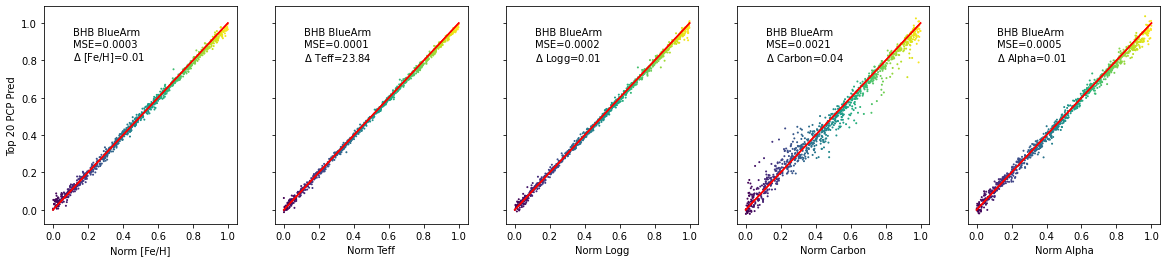

In [163]:
mtype="PCP"
top=20
lr=0.01
x_train, x_test = pcpflux, pcpfluxT
d = DNN(input_dim=top, hidden_dims=[], dp=dp, lr=lr, mtype=mtype)
d.build_model()
d.fit(x_train, y_train, top=top, ep=ep,verbose=0)
y_pred=d.eval(x_test, y_test, WR, Prng)

Layers: [60, 128, 64, 32, 5]
(100000, 60)
| EP 1000 |loss: 0.0040 | mean_: 0.0040 | val_l: 0.0003 | val_m: 0.0003 | lr: 0.0010 | 


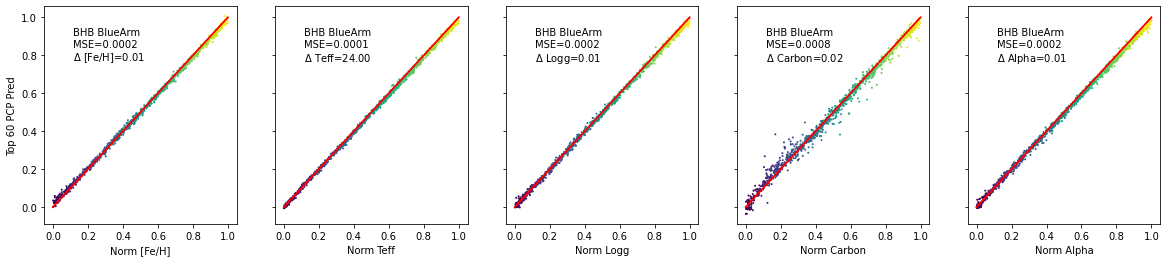

In [168]:
mtype="PCP"
top=60
lr=0.01
x_train, x_test = pcpflux, pcpfluxT
d = DNN(input_dim=top, hidden_dims=[], dp=dp, lr=lr, mtype=mtype)
d.build_model()
d.fit(x_train, y_train, top=top, ep=ep,verbose=0)
y_pred=d.eval(x_test, y_test, WR, Prng)